# Reproducing Optimus 5 Prime Model (CNN - from the Seelig Lab)

In this notebook, we will implement the Optimus 5 Prime Model on the fixed length data, evaluate and analyze the output to be able to compare the performance of other models compared to Optimus 5 Prime. 

In [1]:
import pandas as pd
import numpy as np
import keras
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import  Dense, Embedding, LSTM, Bidirectional
from keras.layers import Dropout
from keras.layers.core import Dense
import seaborn as sns
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
import scipy.stats as stats

from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

## 1. We read the preprocessed data. 

In [2]:
#We load the data
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')

## 2. We split the data in training, validation and testing set.

In [18]:
df = df.sample(frac = 1)

In [19]:
#We divide the test set between training (90%) and testing set (10%)
df_test = df.iloc[:28000]
df_train = df.iloc[28000:]

In [20]:
#All one hot encodings are saved as strings of lists, so we convert them to np.array
X_train = df_train["one-hot encoding"].apply(ast.literal_eval)
y_train = df_train["rl"]

In [21]:
X_train = [np.array(x) for x in X_train]

In [22]:
X_train = np.array(X_train)
X_train.shape

(252000, 50, 4)

In [23]:
#Sanity check 
print("X_train shape: {}".format(X_train.shape))

X_train shape: (252000, 50, 4)


## 3. We build our model and train it using our datasets.

THE FOLLOWING CELL (WITH THE MODEL OPTIMUS 5') HAS BEEN COPY-PASTED FROM THE CODE GIVEN BY THE PAPER. (downloaded here https://www.nature.com/articles/s41587-019-0164-5#MOESM5) 

In [32]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model



In [24]:
def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [34]:
model = train_model(X_train, y_train, nb_epoch=7)

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/7
1969/1969 [==============================] - 127s 64ms/step - loss: 1.2643
Epoch 2/7
1969/1969 [==============================] - 118s 60ms/step - loss: 0.4509
Epoch 3/7
1969/1969 [==============================] - 124s 63ms/step - loss: 0.3262
Epoch 4/7
1969/1969 [==============================] - 132s 67ms/step - loss: 0.2960
Epoch 5/7
1969/1969 [==============================] - 130s 66ms/step - loss: 0.2779
Epoch 6/7
1969/1969 [==============================] - 126s 64ms/step - loss: 0.2651
Epoch 7/7
1969/1969 [==============================] - 122s 62ms/step - loss: 0.2540


In [25]:
#All one hot encodings are saved as strings of lists, so we convert them to np.array for the testing set
X_test = df_test["one-hot encoding"].apply(ast.literal_eval)
X_test = np.array([np.array(x) for x in X_test])

In [26]:
preds = model.predict(X_test).reshape(-1)
preds

array([4.65829  , 8.519486 , 6.17905  , ..., 7.582537 , 5.6078672,
       3.9726396], dtype=float32)

In [27]:
df_test["pred rl"] = preds.tolist()
df_test["pred rl"]

<ipython-input-27-42c4b484d1b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred rl"] = preds.tolist()


123608    4.658290
202865    8.519486
105145    6.179050
273028    7.260701
36860     7.259502
            ...   
275143    6.940334
279524    5.699448
132645    7.582537
216665    5.607867
8909      3.972640
Name: pred rl, Length: 28000, dtype: float64

In [28]:
r = r2(df_test["rl"], df_test["pred rl"])
print('r-squared = ', r)

r-squared =  0.9072680284041672


In [29]:
from sklearn.metrics import r2_score
r2_score(df_test["rl"], df_test["pred rl"])

0.9049102817846972

In [17]:
model.save('./saved_models/optimus_5_prime_fixed_90_10.hdf5')

## 4. We analyze the output

In [10]:
model = keras.models.load_model('./saved_models/optimus_5_prime_fixed_90_10.hdf5')

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

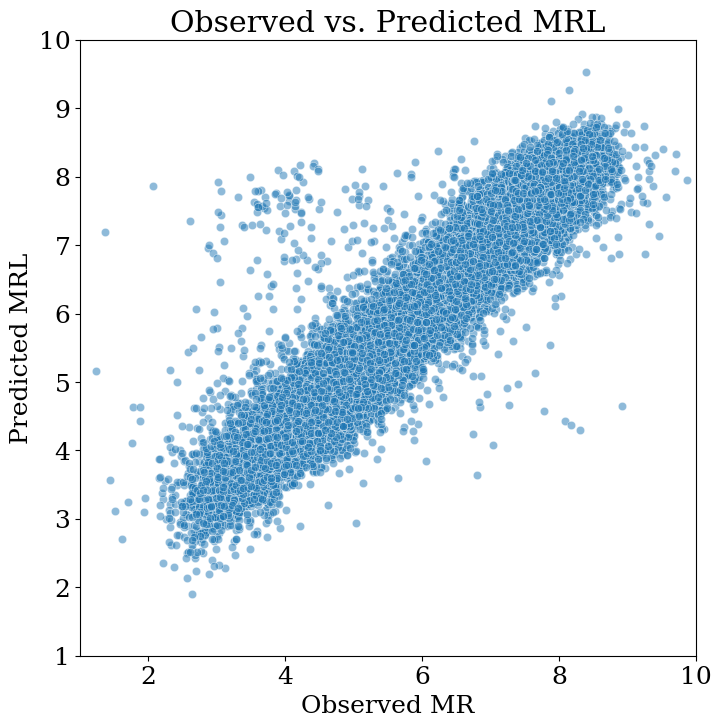

In [30]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test['rl'], df_test["pred rl"],linewidth = 0.5, alpha=0.5)
plt.xlabel('Observed MR')
plt.ylabel('Predicted MRL') 
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('Observed vs. Predicted MRL')
plt.savefig("Optimus_5_prime_fixed.pdf", bbox_inches = "tight")
plt.show()

In [31]:
df_test_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' in x)]
df_test_no_atg = df_test[df_test['utr'].apply(lambda x: 'ATG' not in x)]

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


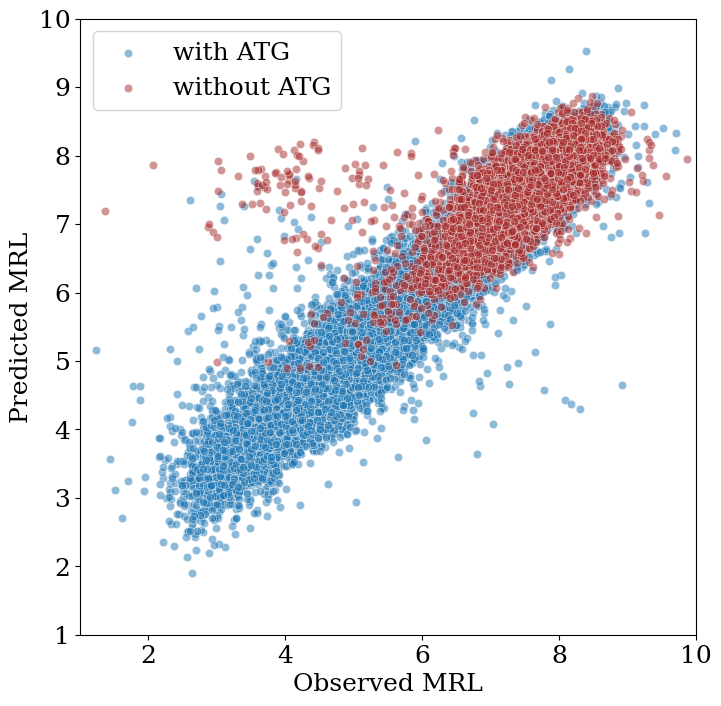

In [32]:
fig = plt.figure(figsize = (8,8))
sns.scatterplot(df_test_atg["rl"], df_test_atg["pred rl"],linewidth = 0.5, alpha=0.5, label = 'with ATG')
ax = sns.scatterplot(df_test_no_atg["rl"], df_test_no_atg["pred rl"],
                 linewidth = 0.5, alpha=0.5, label = 'without ATG', color = 'brown', legend = 'auto')
plt.xlim(1, 10)
plt.ylim(1, 10)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set(xlabel = 'Observed MRL', ylabel = 'Predicted MRL')
plt.savefig("Optimus_5_prime_fixed_atg.pdf", bbox_inches = "tight")
plt.show()

## Analysis of the output

In [26]:
df_test["rl class"] = df_test["rl"].apply(round)
df_test["pred rl class"] = df_test["pred rl"].apply(round)
df_test["pred rl class"]
df_test["rl class"]

<ipython-input-26-ce0e2bb61bb8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["rl class"] = df_test["rl"].apply(round)
<ipython-input-26-ce0e2bb61bb8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred rl class"] = df_test["pred rl"].apply(round)


97706     7
53083     5
50457     7
16280     8
114227    8
         ..
167578    7
1520      5
74322     8
2773      7
31147     5
Name: rl class, Length: 28000, dtype: int64

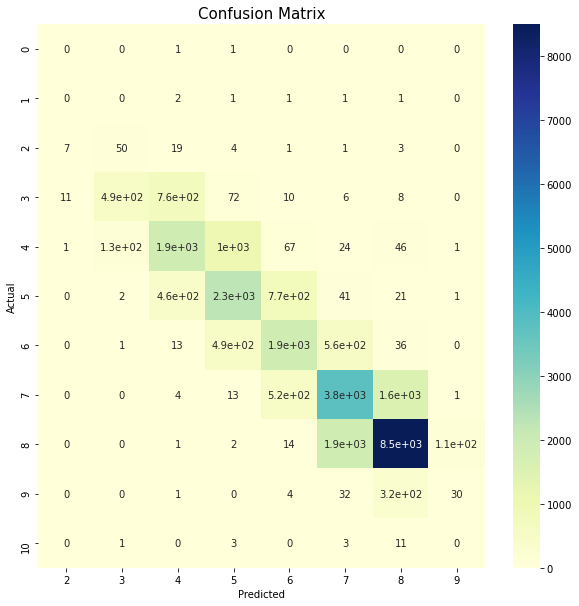

In [27]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(df_test["rl class"], df_test["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

In [28]:
mispredictions_df = df_test[df_test["rl class"] != df_test["pred rl class"]]
mispredictions_df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl,pred rl,rl class,pred rl class
97706,203335,GATCACGGTGCATACGCAGGAGCACGGACTAGATACTGGCGTGTGT...,1.329437e-06,8.695943e-07,1.396575e-06,0.000002,0.000004,0.000004,0.000006,0.000007,...,0.081192,0.066938,7.481407,Selected Data,"[[0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",50,0.624785,7.982724,7,8
53083,92957,CCCCCTGACTCGGCAGACGGCCCGGGGAGTTGGGGGTGCGTCCTGA...,4.023296e-06,5.652363e-06,6.685731e-06,0.000010,0.000010,0.000008,0.000005,0.000003,...,0.051875,0.047199,5.478471,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",50,-0.617936,5.567284,5,6
50457,38197,CGACGACCCGCATCTATTACGCTGGATTGGACAACACTGGATGCAA...,2.378993e-06,1.826148e-06,3.476580e-06,0.000006,0.000007,0.000009,0.000009,0.000006,...,0.061854,0.069243,6.765113,Selected Data,"[[0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,...",50,0.180361,6.045515,7,6
127938,91534,GACTCGGCCTAGACCCCAGTCAGTTATTATTTCTGGTTTCGAACGA...,9.795852e-07,1.347871e-06,7.725733e-07,0.000002,0.000004,0.000005,0.000005,0.000005,...,0.072960,0.081474,7.277242,Selected Data,"[[0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",50,0.498111,7.518586,7,8
71437,51256,CCTAAAGATTGGCGGGACCGGCGTACGGTCCGGATACTATACACAT...,2.134096e-06,1.956587e-06,2.317720e-06,0.000003,0.000003,0.000004,0.000007,0.000007,...,0.085356,0.085785,7.555934,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1,...",50,0.671025,7.102677,8,7


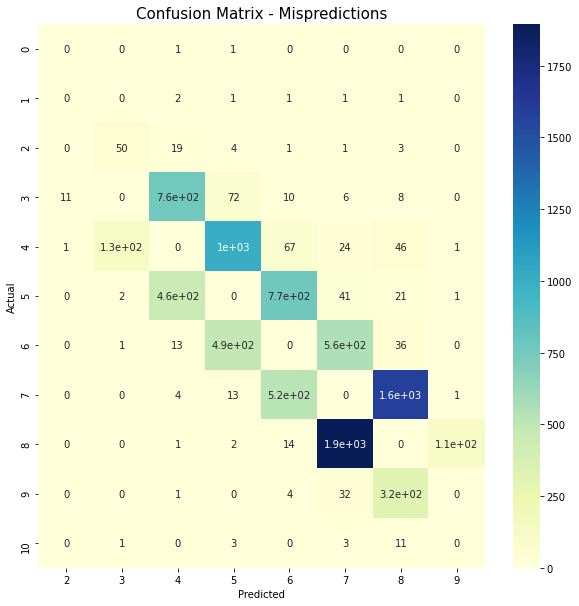

In [29]:
#Confusion matrix of predictions
confusion_matrix = pd.crosstab(mispredictions_df["rl class"], mispredictions_df["pred rl class"], rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix - Mispredictions", fontsize = 15)
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_test = df_test["rl class"]
y_pred = df_test["pred rl class"]

print("Precision Score : ",precision_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.6731428571428572
Recall Score :  0.6731428571428572


/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1267: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
